In [66]:
multi_sentence_text = """The Monte Carlo algorithm (or Monte Carlo method) refers to a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. These methods are used in various fields such as finance, physics, engineering, and AI for problems that are deterministic in principle but difficult to solve directly.

Key Aspects of the Monte Carlo Algorithm:
Random Sampling: The core idea is to generate random variables to simulate complex systems or processes. The algorithm uses probabilistic models and generates numerous random samples to approximate the solution to a deterministic problem.

Estimation of Results: Monte Carlo methods provide estimates of the outcome by running many simulations and averaging the results. These results tend to get more accurate as the number of trials increases (according to the law of large numbers).

Applications:

Numerical Integration: When integrals are difficult to evaluate analytically, Monte Carlo methods approximate them by averaging sampled values.
Optimization: Used in scenarios like stochastic optimization, where exact solutions are hard to compute.
Statistical Inference: Monte Carlo is used in Bayesian inference to estimate posterior distributions.
Simulations: For example, in finance to model stock prices or risks.
Basic Process:
Define a Problem: The first step is to define a domain of possible inputs (often high-dimensional and complex).

Generate Random Samples: Randomly generate inputs from a probability distribution over the domain.

Compute Results: Evaluate the function or process for each randomly generated input.

Average the Results: Use the results to compute an average or distribution of outputs, which serves as the approximation to the problem.

Example: Estimating Pi
A common example is using the Monte Carlo method to estimate Pi:

Consider a circle of radius 1 inside a square with sides of length 2.
Generate random points in the square.
The ratio of points that fall inside the circle to the total number of points is approximately Pi/4. By multiplying this ratio by 4, you can estimate the value of Pi.
Advantages:
Scalability: Works well with problems of high-dimensional spaces.
Simplicity: The algorithm is easy to implement and doesn't require detailed knowledge of the problem.
Flexibility: It can be applied to a wide range of problems where deterministic solutions are not feasible.
Disadvantages:
Convergence Time: The algorithm may require a large number of samples to converge to an accurate solution, which can be computationally expensive.
Accuracy: As it is based on random sampling, the result is an approximation and not an exact answer.
Monte Carlo algorithms are especially useful in scenarios where exact mathematical modeling is difficult or impossible, but simulation can provide insights or approximate solutions."""

In [67]:

from langchain_text_splitters import RecursiveCharacterTextSplitter


In [68]:

splitter_r = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap= 100
)
sentences = splitter_r.split_text(multi_sentence_text)

data = {i+1: sentence for i, sentence in enumerate(sentences)}

for sentence in data.items():
    print(f"{sentence}")


(1, 'The Monte Carlo algorithm (or Monte Carlo method) refers to a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. These methods are used in various fields such as finance, physics, engineering, and AI for problems that are deterministic in principle but difficult to solve directly.')
(2, 'Key Aspects of the Monte Carlo Algorithm:\nRandom Sampling: The core idea is to generate random variables to simulate complex systems or processes. The algorithm uses probabilistic models and generates numerous random samples to approximate the solution to a deterministic problem.')
(3, 'Estimation of Results: Monte Carlo methods provide estimates of the outcome by running many simulations and averaging the results. These results tend to get more accurate as the number of trials increases (according to the law of large numbers).\n\nApplications:')
(4, 'Numerical Integration: When integrals are difficult to evaluate analytically, Monte Carlo m

In [69]:
import re

from abc import ABC, abstractmethod
from typing import Union, List
from re import Pattern


class AbstractSplitter(ABC):
   """ The abstract class for text splitters. """
    @abstractmethod
    def split(self):
        pass


class TextSplitterV3(AbstractSplitter):
    """ The dynamic text splitter for dividing text into chunks with
    margin windows.

    <b>Important:</b>
        1) The order of the separators is important for the "sequential" and
        "backward" order. The first separator in the list will be the first
        separator to be checked for in the text. The algorithm will early
        stop when finds the first occurence of the separator.

        2) When initiziled, the class is optimized for the given separators.
        If the separators are changed, the class should be reinitizalized or
        the setup_separators method should be called.

        3) We advise to use a proposed sizes of the chunk size, overlap and
        margin. Refer to the R&D in documentation where experimentation was
        performed.

        4) The results are currently in reverse order.

    Parameters:
        chunk_size: [int | float]
            Requested size of the chunk.
        overlap: int
            The overlap between the chunks
        order: str ["any", "sequntial", "backward"]
            The search strategy for the separators
        separators: List[str]
            List of separators to be used for splitting the text
        is_separator_regex: bool
            If the provided separators are regex or not

    """
    def __init__(
            self,
            chunk_size: int = 1024,
            chunk_overlap: Union[int, float] = 256,
            margin: int = 256,
            order: str = "any",
            separators: List[str] = ['\.', '\n\n', '\n', '\s'],
            is_separator_regex: bool = True,
    ):
        self.chunk_size = chunk_size
        self.overlap = chunk_overlap
        self.margin = margin
        self.order = order
        self._is_separator_regex = is_separator_regex
        self.separators = separators

        if any(property is None for property in self.__dict__.values()):
            raise ValueError(
                "All properties must be set to a value."
            )

        if isinstance(chunk_overlap, float):
            chunk_overlap = int(chunk_overlap * chunk_size)

        if chunk_size <= 0:
            raise ValueError(
                f"Chunk size {chunk_size} must be greater than 0."
            )

        if 0 > chunk_overlap or chunk_overlap >= chunk_size:
            raise ValueError(
                f"Overlap size {chunk_overlap} is greater than the chunk size"
                f" {chunk_size}."
            )

        if 0 > margin or margin > chunk_size:
            raise ValueError(
                f"Margin size {margin} is greater than the chunk size"
                f" {chunk_overlap}."
            )

        self.separator_pattern: Union[Pattern, List[Pattern], None] = None
        self.search_func: callable = None
        self.setup_separators(separators)

    def setup_separators(self, separators):
        """ Prepares compiled patterns for efficient search of the separators
        and sets the search function based on the order of the separators.
        """
        match self.order.lower():
            case "any":
                if not self._is_separator_regex:
                    separators = '|'.join([
                        re.escape(separator) for separator in separators
                    ])
                else:
                    separators = '|'.join(separators)
                self.separator_pattern = re.compile(separators)
                self.search_func = self.search_re
            case "sequential":
                if not self._is_separator_regex:
                    self.separator_pattern = [
                        re.compile(re.escape(separator))
                        for separator in separators
                    ]
                else:
                    self.separator_pattern = [
                        re.compile(separator)
                        for separator in separators
                    ]
                self.search_func = self.search_re_list
            case "backward":
                if not self._is_separator_regex:
                    self.separator_pattern = [
                        re.compile(re.escape(separator))
                        for separator in reversed(separators)
                    ]
                else:
                    self.separator_pattern = [
                        re.compile(separator)
                        for separator in reversed(separators)
                    ]
                self.search_func = self.search_re_list
            case _:
                raise ValueError(
                    f"Choosen invalid order: {self.order}"
                    "Choose from: ['any', 'sequential', 'backward']"
                )

    def search_re(self, pattern, string):
        return pattern.search(string)

    def search_re_list(self, pattern, string):
        for p in pattern:
            result = p.search(string)
            if not isinstance(result, type(None)):
                return result
        return None

    def split(self, text):
        """ Splits text into chunks dynamically

        Algorithm:

        0'th iteration:

        1. Calculate the maximum chunk size
            The difference between the chunk size and the overlap
            that assures that the final chunk will not exceed but
            be as high as possible. (We want final chunk sizes as
            close to the chunk size as possible)

        2. Get text length
            The algorithms operates on the text length as the indexing
            medium insted of operating on the text itself. This allows
            us to increase performance by not having to slice the text.

        3. Calculate the starting split position (see _start_split_position)
        4. Creation of the last chunk (we are chunking in reverse)
        5. Update the remaining text length


        The loop:
            While the remaining text length is greater than the maximum chunk
            size~

        1. Calculate the starting split position (see _start_split_position)
        2. Calculate the ending split position (see _end_split_position)
        3. Append the chunk to the chunks with the calculated positions
        4. Update the remaining text length

        The finale:
        1. Append the first chunk to the chunks from last starting split
            positionto the beginning of the text.

        2. Return the chunks in reverse order

        """
        remaining_text_length = len(text)

        static_split_position = self.chunk_size
        new_end_position = self._split_neg(
            text[static_split_position-self.margin:static_split_position],
            static_split_position
        )
        splits = [text[0:new_end_position]]

        while new_end_position < remaining_text_length:
            static_split_position -= self.overlap
            
            new_start_pos = self._split_pos(
                text[static_split_position:static_split_position+self.margin],
                static_split_position
            )
            static_split_position += self.chunk_size
            new_end_position = self._split_neg(
                text[static_split_position-self.margin:static_split_position],
                static_split_position
            )

            splits.append(text[new_start_pos:new_end_position])

        if new_end_position >= remaining_text_length:
            return splits

        static_split_position -= self.overlap
        new_start_pos = self._split_pos(
            text[static_split_position:static_split_position+self.margin],
            static_split_position
        )
        splits.append(text[new_start_pos::])

        return splits

    def _split_pos(self, string, current_position):
        offset = self.search_func(self.separator_pattern, string)
        if offset is None:
            return current_position

        return current_position + offset.end()

    def _split_neg(self, string, current_position):
        inverted_string = string[::-1]
        offset = self.search_func(self.separator_pattern, inverted_string)
        if offset is None:
            return current_position

        return current_position - offset.start()

ts = TextSplitterV3(
    chunk_size=500,
    chunk_overlap=100,
    margin=50)
result_custom = ts.split(
    multi_sentence_text
)

display(result_custom)


['The Monte Carlo algorithm (or Monte Carlo method) refers to a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. These methods are used in various fields such as finance, physics, engineering, and AI for problems that are deterministic in principle but difficult to solve directly.\n\nKey Aspects of the Monte Carlo Algorithm:\nRandom Sampling: The core idea is to generate random variables to simulate complex systems or processes. The algorithm ',
 'core idea is to generate random variables to simulate complex systems or processes. The algorithm uses probabilistic models and generates numerous random samples to approximate the solution to a deterministic problem.\n\nEstimation of Results: Monte Carlo methods provide estimates of the outcome by running many simulations and averaging the results. These results tend to get more accurate as the number of trials increases (according to the law of large numbers).\n\nApplications:\n\nNum

Comparison of chunk size distribution:

In [70]:
result_lang = splitter_r.split_text(multi_sentence_text)
print("Langchain Splitter")
for i, sentence in enumerate(result_lang):
    print(f"#{i+1}: {len(sentence)}")

result_custom = ts.split(multi_sentence_text)

print("Custom Splitter")
for i, sentence in enumerate(result_custom):
    print(f"#{i+1}: {len(sentence)}")

Langchain Splitter
#1: 337
#2: 280
#3: 260
#4: 434
#5: 195
#6: 411
#7: 454
#8: 369
#9: 181
Custom Splitter
#1: 500
#2: 491
#3: 490
#4: 486
#5: 484
#6: 491
#7: 445


## Comparison of methods

In [71]:
large_text = " ".join([multi_sentence_text for _ in range(0, 150)])

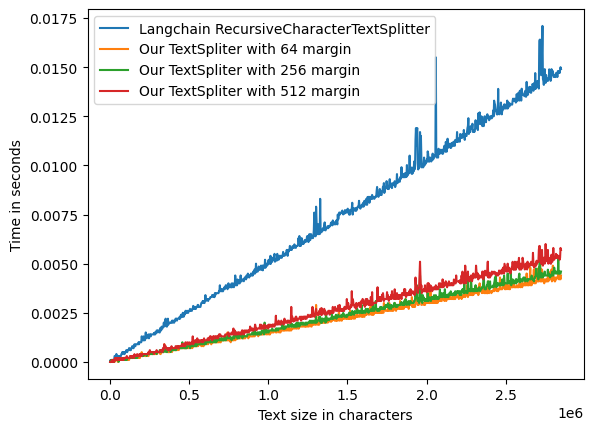

In [72]:
import matplotlib.pyplot as plt
from time import time


splitter_r = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap= 256
)

ts1 = TextSplitterV3(
    chunk_size=1024,
    chunk_overlap=256,
    margin=64,
    order="any"
)

ts2 = TextSplitterV3(
    chunk_size=1024,
    chunk_overlap=256,
    margin=256,
    order="any"
)

ts3 = TextSplitterV3(
    chunk_size=1024,
    chunk_overlap=256,
    margin=512,
    order="any"
)

multiplier = 1000

times_lang_r = []
times_custom_1 = []
times_custom_2 = []
times_custom_3 = []

for i in range(1, multiplier):
    large_text = " ".join([multi_sentence_text for _ in range(0, i)])
    start_time = time()
    [splitter_r.split_text(large_text) for _ in range(0, 10)]
    exec_time_lang_r = (time()-start_time)/10

    start_time = time()
    [ts1.split(large_text) for _ in range(0, 10)]
    exec_time_custom_1 = (time()-start_time)/10

    start_time = time()
    [ts2.split(large_text) for _ in range(0, 10)]
    exec_time_custom_2 = (time()-start_time)/10

    start_time = time()
    [ts3.split(large_text) for _ in range(0, 10)]
    exec_time_custom_3 = (time()-start_time)/10

    times_lang_r.append(exec_time_lang_r)
    times_custom_1.append(exec_time_custom_1)
    times_custom_2.append(exec_time_custom_2)
    times_custom_3.append(exec_time_custom_3)

text_size = len(multi_sentence_text)

plot = plt.figure()
plt.plot(range(text_size, multiplier*text_size, text_size), times_lang_r, label="Langchain RecursiveCharacterTextSplitter")
plt.plot(range(text_size, multiplier*text_size, text_size), times_custom_1, label="Our TextSpliter with 64 margin")
plt.plot(range(text_size, multiplier*text_size, text_size), times_custom_2, label="Our TextSpliter with 256 margin")
plt.plot(range(text_size, multiplier*text_size, text_size), times_custom_3, label="Our TextSpliter with 512 margin")
plt.xlabel("Text size in characters")
plt.ylabel("Time in seconds")
plt.legend()

In [73]:
import plotly.graph_objs as go

plt = go.Figure()

plt.add_trace(go.Scatter(
    x=list(range(text_size, 1000*text_size, text_size)),
    y=times_lang_r,
    mode="lines",
    name="Langchain RecursiveCharacterTextSplitter"
))

plt.add_trace(go.Scatter(
    x=list(range(text_size, 1000*text_size, text_size)),
    y=times_custom_1,
    mode="lines",
    name="Our TextSpliter with 64 margin"
))

plt.add_trace(go.Scatter(
    x=list(range(text_size, 1000*text_size, text_size)),
    y=times_custom_2,
    mode="lines",
    name="Our TextSpliter with 256 margin"
))

plt.add_trace(go.Scatter(
    x=list(range(text_size, 1000*text_size, text_size)),
    y=times_custom_3,
    mode="lines",
    name="Our TextSpliter with 512 margin"
))

plt.update_layout(
    title="Execution time of text splitters",
    xaxis_title="Text size in characters",
    yaxis_title="Time in seconds",
    template="plotly_dark",
    legend=dict(
        x=0.01,
        y=0.99
    )
)

plt.show()

In [74]:
import plotly.graph_objs as go

plt = go.Figure()


chunk_size = 1024
chunk_overlap = 256

splitter_r = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

ts1 = TextSplitterV3(
    chunk_size=1024,
    chunk_overlap=256,
    margin=256,
    order="any"
)

ts2 = TextSplitterV3(
    chunk_size=1024,
    chunk_overlap=256,
    margin=256,
    order="sequential"
)

lengths_lang_r = []
lengths_custom_1 = []
lengths_custom_2 = []
lengths_custom_3 = []
lengths_custom_4 = []
text_size = len(multi_sentence_text)

for i in range(3, 5):
    large_text = " ".join([multi_sentence_text for _ in range(0, i)])
    splits = [splitter_r.split_text(large_text) for _ in range(0, 1)]
    length_lang_r = [
        len(sentence) for split in splits for sentence in split
    ]

    splits = [ts1.split(large_text) for _ in range(0, 1)]
    length_custom_1 = [
        len(sentence) for split in splits for sentence in split
    ]

    splits = [ts2.split(large_text) for _ in range(0, 1)]
    length_custom_2 = [
        len(sentence) for split in splits for sentence in split
    ]

    lengths_lang_r.extend(length_lang_r)
    lengths_custom_1.extend(length_custom_1)
    lengths_custom_2.extend(length_custom_2)


print("Langchain RecursiveCharacterTextSplitter\n", lengths_lang_r)
print("Our TextSpliter with 256 margin any\n", lengths_custom_1)
print("Our TextSpliter with 256 margin sequential\n", lengths_custom_2)


plt.add_trace(go.Violin(
    y=lengths_lang_r,
    name="Langchain RecursiveCharacterTextSplitter",
    box_visible=True,
    meanline_visible=True
))

plt.add_trace(go.Violin(
    y=lengths_custom_1,
    name="Our TextSpliter with 256 margin 'any'",
    box_visible=True,
    meanline_visible=True
))

plt.add_trace(go.Violin(
    y=lengths_custom_2,
    name="Our TextSpliter with 256 margin 'sequential'",
    box_visible=True,
    meanline_visible=True
))

plt.update_layout(
    title="Length distributions of chunks (1024)",
    yaxis_title="Length of the chunk",
    template="plotly_dark",

)


Langchain RecursiveCharacterTextSplitter
 [881, 974, 824, 767, 542, 974, 824, 767, 542, 974, 1006, 881, 974, 824, 767, 542, 974, 824, 767, 542, 974, 824, 767, 542, 974, 1006]
Our TextSpliter with 256 margin any
 [1019, 1016, 1018, 1014, 1007, 1020, 1013, 1020, 1021, 1015, 868, 1019, 1016, 1018, 1014, 1007, 1020, 1013, 1020, 1021, 1015, 1019, 1010, 1015, 1013, 641]
Our TextSpliter with 256 margin sequential
 [866, 887, 790, 783, 896, 925, 755, 903, 944, 963, 798, 866, 887, 790, 783, 896, 925, 755, 903, 944, 963, 798, 867, 864, 876, 552]
